In [64]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [65]:
filenames = os.listdir("newimages")
categories = []
for filename in filenames:
    category = filename[:4]
    if category == 'bird':
        categories.append(0)
    else:
        categories.append(1)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

df = df.sample(frac=1)

In [66]:
df.head()

,filename,category
4171,bird4350.jpg,0
6021,squirrel1126.jpg,1
2381,squirrel1984.jpg,1
2138,squirrel1572.jpg,1
1996,squirrel197.jpg,1


In [67]:
df.tail()

,filename,category
4836,squirrel3708.jpg,1
4894,squirrel458.jpg,1
4591,bird1.jpg,0
2348,squirrel1199.jpg,1
1681,bird1152.jpg,0


<AxesSubplot: >

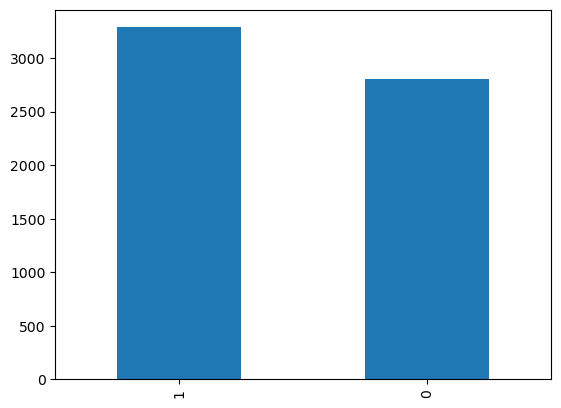

In [68]:
df['category'].value_counts().plot.bar()

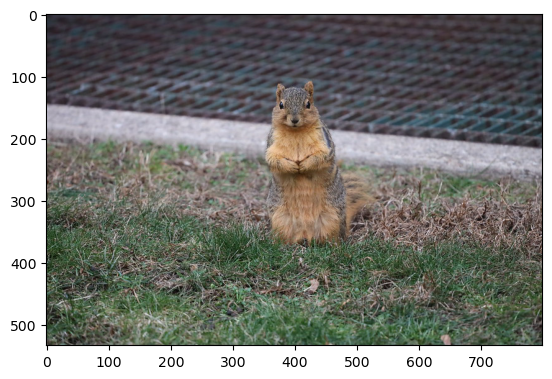

In [69]:
sample = random.choice(filenames)
image = load_img("newimages/"+sample)
plt.imshow(image)

In [70]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_8 (Batc  (None, 126, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_9 (Batc  (None, 61, 61, 64)      

In [71]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('trained models/model2.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')


#earlystop = EarlyStopping(patience=10)
#learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

callbacks = [earlyStopping, mcp_save, reduce_lr_loss]

In [72]:
df["category"] = df["category"].replace({0: 'bird', 1: 'squirrel'})

In [73]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot: >

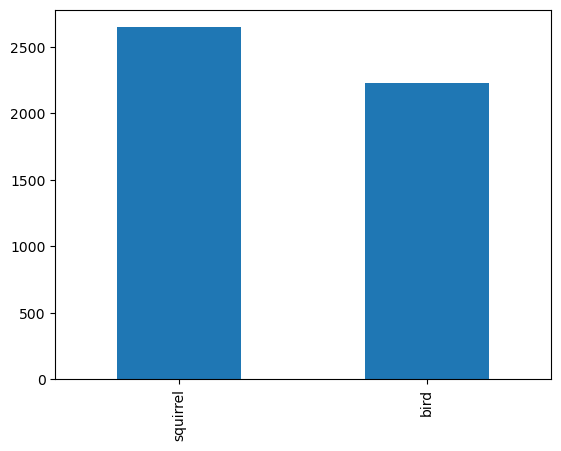

In [74]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot: >

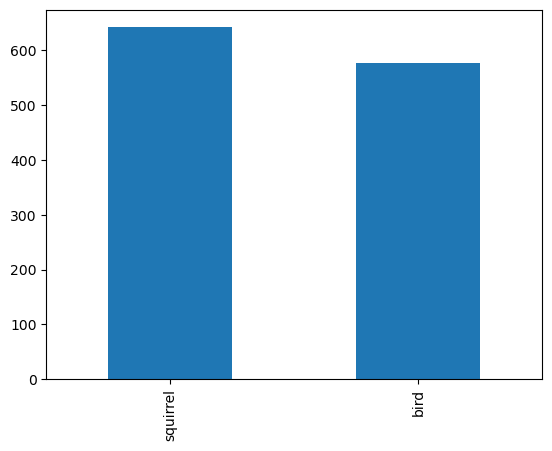

In [75]:
validate_df['category'].value_counts().plot.bar()

In [76]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [77]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "newimages", 
    x_col='filename',
    y_col='category',
    target_size=(128,128),
    class_mode='categorical',
    batch_size=batch_size
)

Found 4874 validated image filenames belonging to 2 classes.


In [78]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "newimages", 
    x_col='filename',
    y_col='category',
    target_size=(128,128),
    class_mode='categorical',
    batch_size=batch_size
)

Found 1219 validated image filenames belonging to 2 classes.


In [79]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "newimages", 
    x_col='filename',
    y_col='category',
    target_size=(128,128),
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


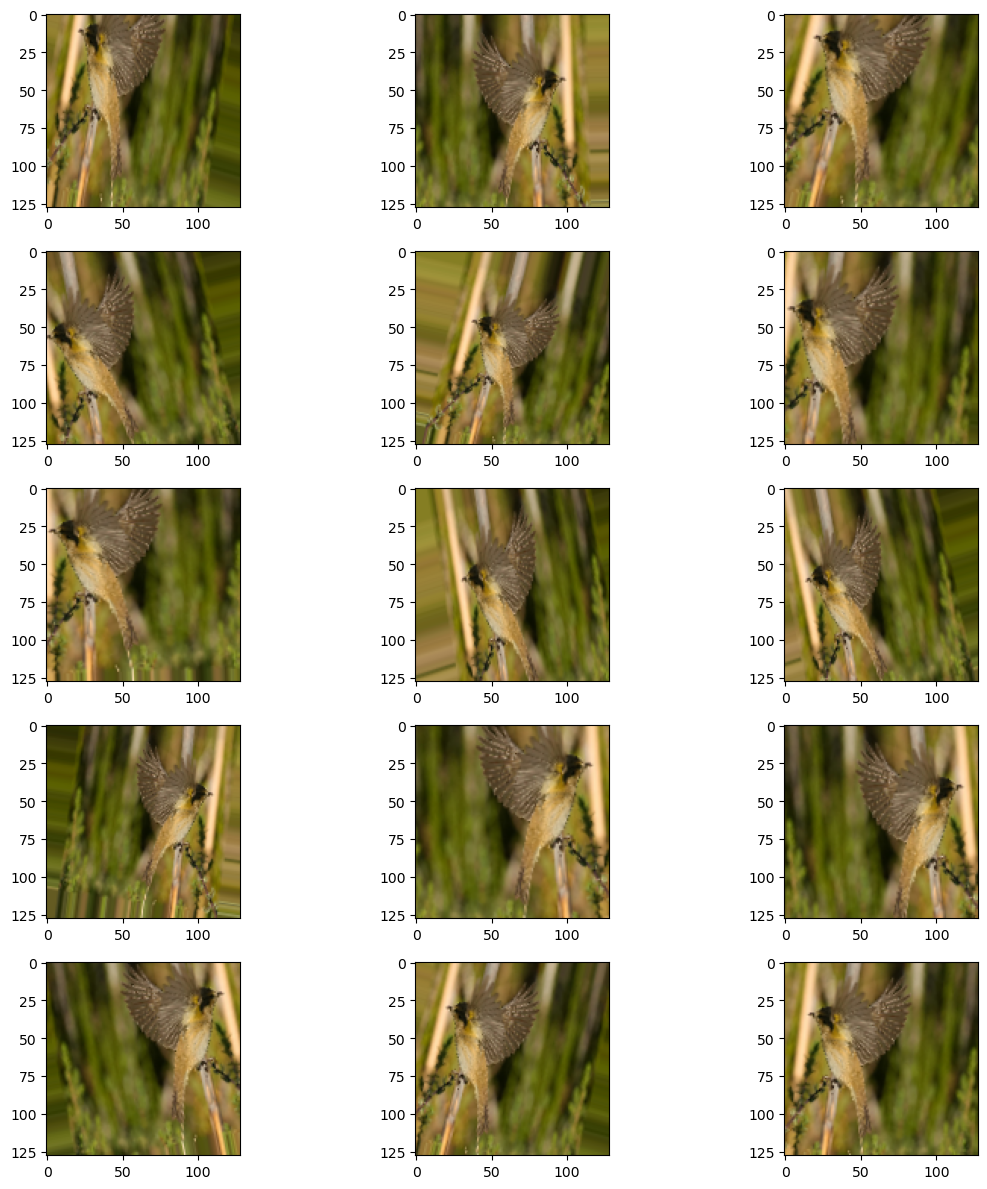

In [80]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [81]:
history = model.fit(
    train_generator, 
    epochs=50,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50


2023-01-27 09:51:25.001891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


324/324 [==============================] - ETA: 0s - loss: 0.9080 - accuracy: 0.6563

2023-01-27 09:52:01.449357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


324/324 [==============================] - 43s 130ms/step - loss: 0.9080 - accuracy: 0.6563 - val_loss: 0.7137 - val_accuracy: 0.5449 - lr: 0.0010
Epoch 2/50
324/324 [==============================] - 42s 129ms/step - loss: 0.5866 - accuracy: 0.7213 - val_loss: 0.6216 - val_accuracy: 0.7202 - lr: 0.0010
Epoch 3/50
324/324 [==============================] - 41s 128ms/step - loss: 0.5455 - accuracy: 0.7382 - val_loss: 0.5937 - val_accuracy: 0.7012 - lr: 0.0010
Epoch 4/50
324/324 [==============================] - 41s 127ms/step - loss: 0.5017 - accuracy: 0.7689 - val_loss: 0.4706 - val_accuracy: 0.7819 - lr: 0.0010
Epoch 5/50
324/324 [==============================] - 41s 126ms/step - loss: 0.4583 - accuracy: 0.7891 - val_loss: 0.7368 - val_accuracy: 0.6971 - lr: 0.0010
Epoch 6/50
324/324 [==============================] - 1695s 5s/step - loss: 0.4369 - accuracy: 0.8033 - val_loss: 0.5925 - val_accuracy: 0.7712 - lr: 0.0010
Epoch 7/50
324/324 [==============================] - 42s 129ms/